In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm
import random
import seaborn as sns; sns.set()

In [18]:
from common import get_data, get_freq_data, signal_cyclic_shift, get_ref_time, generate_multi_signal

In [19]:
X_two_signals, y_two_signals = get_data(data_path='./data/na62_11_pulses.txt')


In [20]:
X_two_signals_train, X_two_signals_test, y_two_signals_train, y_two_signals_test = train_test_split(X_two_signals,\
                                                                                    y_two_signals, test_size=0.2, shuffle=False)

In [31]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        signal = generate_multi_signal(X_origin, y_origin, alpha)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['multi_ref_time']) 
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [22]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


# tau_train_range = list(map(int, get_truncated_normal(mean=0, sd=5, low=-20, upp=20).rvs(1000)))
# tau_test_range = list(map(int, get_truncated_normal(mean=0, sd=5, low=-20, upp=20).rvs(1000)))
alpha_train_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 0.05, 0.05)])
alpha_test_range = np.array([0, 0.01, 0.05, 0.1, 0.5])
freq_values = [1, 25, 50, 75, 100]

In [23]:
import xgboost as xgb
from sklearn.model_selection import cross_validate
from math import sqrt

In [24]:
[np.round(alpha, decimals=3) for alpha in alpha_train_range[::10]]

[0.001, 0.003, 0.01, 0.032, 0.1, 0.316, 1.0]

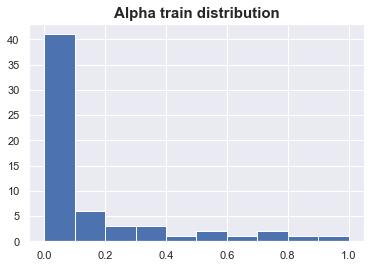

In [25]:
plt.title("Alpha train distribution",  weight='bold', fontsize=15)
plt.hist(alpha_train_range)
plt.show()

In [26]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

In [27]:
# TIME_SCALE_COEF = 0.2
# plt.title("Tau train distribution", weight='bold', fontsize=15)
# plt.hist(np.array(tau_train_range)*TIME_SCALE_COEF)
# plt.xlabel("Tau [ns]")

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
two_signals_scores = {alpha:[] for alpha in alpha_test_range}

In [30]:
model = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)

In [32]:
TEST_SIZE = len(X_two_signals_test)
TIME_SCALE_COEF = 0.2

for freq in freq_values:
    X_train, y_train = prepare_data(X_two_signals_train, y_two_signals_train, alpha_train_range, data_size=len(X_two_signals))
    X_train_freq = get_freq_data(X_train, freq=freq)
    model.fit(X_train_freq, y_train)
    
    for alpha in tqdm.tqdm_notebook(alpha_test_range):
        X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, [alpha], data_size=TEST_SIZE)
        X_test_freq = get_freq_data(X_test_cur, freq=freq)
        y_pred = model.predict(X_test_freq)
        two_signals_scores[alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)

100%|██████████| 5/5 [00:00<00:00,  8.67it/s]


In [33]:
alpha_one_signal_test = [0, 0.01, 0.05, 0.1, 0.5] 
one_signal_scores = {alpha: [] for alpha in alpha_one_signal_test} 
one_signal_scores[-1] = [] ### -1 - predict for one signal data

In [34]:
model = xgb.XGBRegressor(objective="reg:linear", alpha= 0.00244, booster='dart', eta= 0.017326, gamma=0.19504, 
                           reg_lambda=0.22451, max_depth=8, verbosity=0)

In [35]:
X_one_signal, y_one_signal = get_data('./data/na62_11_pulses.txt')

In [36]:
X_one_signal_train, X_one_signal_test, y_one_signal_train, y_one_signal_test = train_test_split(X_one_signal,\
                                                                                    y_one_signal, test_size=0.2, shuffle=False)

In [37]:
for freq in tqdm.tqdm_notebook(freq_values):
    X_train_freq = get_freq_data(X_one_signal_train, freq=freq)
    model.fit(X_train_freq, y_one_signal_train)
    X_test_freq = get_freq_data(X_one_signal_test, freq=freq)
    y_pred = model.predict(X_test_freq)
    one_signal_scores[-1].append(sqrt(mean_squared_error(y_pred, y_one_signal_test)) * TIME_SCALE_COEF)

100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


In [38]:
for freq in freq_values:
    X_train_freq = get_freq_data(X_one_signal_train, freq=freq)
    model.fit(X_train_freq, y_one_signal_train)
    
    for alpha in tqdm.tqdm_notebook(alpha_one_signal_test):
        X_test_cur, y_test_cur = prepare_data(X_two_signals_test, y_two_signals_test, [alpha], data_size=TEST_SIZE)
        X_test_freq = get_freq_data(X_test_cur, freq=freq)
        y_pred = model.predict(X_test_freq)
        one_signal_scores[alpha].append(sqrt(mean_squared_error(y_pred, y_test_cur)) * TIME_SCALE_COEF)

100%|██████████| 5/5 [00:00<00:00,  8.60it/s]


In [39]:
one_signal_scores

{0: [0.11632956702597944,
  0.13814164621816466,
  0.24282056420806264,
  0.8712977400168929,
  1.2912703370907916],
 0.01: [0.11158787951012626,
  0.17182831571185797,
  0.3246461917552015,
  0.9212870031091418,
  1.1663963721677029],
 0.05: [0.16752363444672208,
  0.37135940851366434,
  0.8928602230825207,
  1.1128188499070601,
  1.3128312459569715],
 0.1: [0.24647089718295412,
  0.5083012929961156,
  1.013338773983966,
  0.9509421587291925,
  1.452732294261905],
 0.5: [1.2626942726345014,
  1.445108509729701,
  1.71545861364653,
  1.6027309529937803,
  2.0665048634546936],
 -1: [0.11789278609158937,
  0.13896637518074567,
  0.23537545145889524,
  0.8875224293234478,
  1.2317380953542514]}

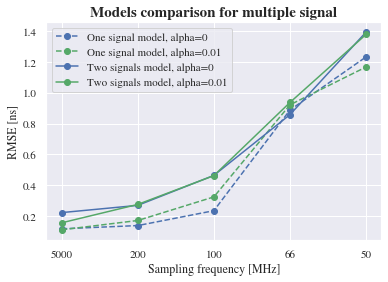

In [40]:
colors = ['b', 'g']

ORIGIN_FREQ = 5000

plt.plot(one_signal_scores[-1], marker='o', linestyle='--', color=colors[0])

for i, alpha in enumerate(alpha_one_signal_test[1:2], 1):
    plt.plot(one_signal_scores[alpha], marker='o', linestyle='--', color=colors[i])
for i, alpha in enumerate(alpha_one_signal_test[:2], 0):
    plt.plot(two_signals_scores[alpha], marker='o', color=colors[i])

plt.title("Models comparison for multiple signal", weight='bold', fontsize=15)
plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["One signal model, alpha=" + str(a) for a in alpha_one_signal_test[:2]] +\
                      ["Two signals model, alpha=" + str(a) for a in alpha_one_signal_test[:2]])
plt.show()

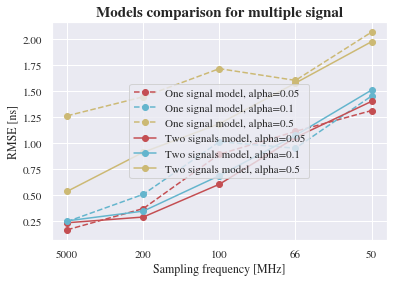

In [41]:
colors = ['r', 'c', 'y']


ORIGIN_FREQ = 5000

for i, alpha in enumerate(alpha_one_signal_test[2:], 0):
    plt.plot(one_signal_scores[alpha], marker='o', linestyle='--', color=colors[i])
for i, alpha in enumerate(alpha_one_signal_test[2:], 0):
    plt.plot(two_signals_scores[alpha], marker='o', color=colors[i])

plt.title("Models comparison for multiple signal", weight='bold', fontsize=15)
plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["One signal model, alpha=" + str(a) for a in alpha_one_signal_test[2:]] +\
                      ["Two signals model, alpha=" + str(a) for a in alpha_one_signal_test[2:]], loc='center')
plt.show()

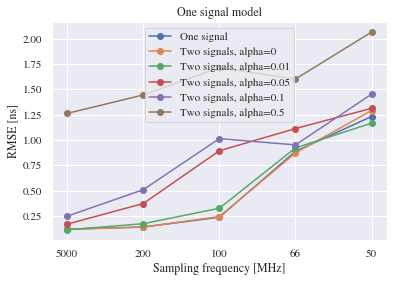

In [43]:
ORIGIN_FREQ = 5000


plt.title("One signal model")
for alpha in [-1] + alpha_one_signal_test:
    plt.plot(one_signal_scores[alpha], marker='o')
plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(["One signal"] + ["Two signals, alpha=" + str(a) for a in alpha_one_signal_test])
plt.show()

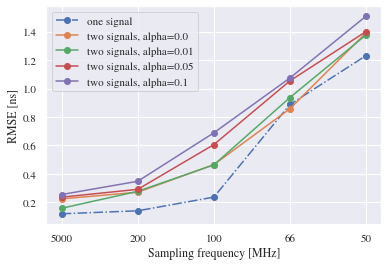

In [45]:
plt.plot(one_signal_scores[-1], marker='o', linestyle='-.')

for alpha in list(two_signals_scores.keys())[:4]:
    plt.plot(two_signals_scores[alpha], marker='o', linestyle='-')

plt.ylabel("RMSE [ns]")
plt.xlabel("Sampling frequency [MHz]")
plt.xticks(range(len(freq_values)), [int(ORIGIN_FREQ/freq) for freq in freq_values])
plt.legend(['one signal'] + ['two signals, alpha=' + str(key) for key in two_signals_scores.keys()])
plt.show()

### -----------------------------------------------

In [ ]:
X_two_signals, y_two_signals = get_data(is_one_signal=False)
mean_argmin =  int(np.argmin(X_two_signals, axis=1).mean())

X_two_signals_train, X_two_signals_test, y_two_signals_train, y_two_signals_test = train_test_split(X_two_signals,\
                                                                                    y_two_signals, test_size=0.2, shuffle=False)

In [ ]:
X_one_signal, y_one_signal = get_data(is_one_signal=True)

In [ ]:
X_one_signal_train, X_one_signal_test, y_one_signal_train, y_one_signal_test = train_test_split(X_one_signal,\
                                                                                    y_one_signal, test_size=0.2, shuffle=False)

In [ ]:
X_one_signal_test.shape

In [ ]:
X_two_signals_test.shape

In [ ]:
for i in range(len(X_two_signals_test)):
    cur_argmin = np.argmin(X_two_signals_test[i])
    X_two_signals_test[i] = signal_cyclic_shift(X_two_signals_test[i], mean_argmin - cur_argmin)
    y_two_signals_test[i] += mean_argmin - cur_argmin

In [ ]:
plt.hist(y_one_signal_test)

In [ ]:
plt.hist(y_two_signals_test)

In [ ]:
X_two_signals_test[0]

In [ ]:
X_one_signal_test[0]

### --------------------------------------------

In [ ]:
FONTSIZE=15

In [ ]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

In [ ]:
plt.title("One signal", weight='bold', fontsize=FONTSIZE)
plt.plot(X_one_signal[0])
plt.show()

In [ ]:
tau = 40
alpha = 0.5
multiple_signal = generate_multi_signal(X_two_signals, y_two_signals, tau, alpha)['multi_impulse']
plt.title("Multiple signal, tau = %d, alpha = %0.1f" %(tau, alpha), weight='bold', fontsize=FONTSIZE)
plt.plot(multiple_signal)
plt.show()

In [ ]:
plt.title("Mu")